# Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import glob
import datetime
import time
import copy

import dataloader as dl
import goesimager as im

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT

np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
vol = '/Users/stock/Development/research/soundings/data/subset/'

GOES-16, NWP RAP/HRRR, RTMA, Radiosonde
---

- Radiosonde
    - Date
    - Latitude/Longitude
    - Elevation
    
- RTMA
    - Regional surface values Pressure/Temperature/Dew Point

- NWP
    - Regional model with isobaric values
        - v/u wind component
        - cloud ice
        - temperature
        - dew point
        - specific humidity
        
- GOES-16
    - Regional model capturing bands 8, 9, 10, 11, 13, 14, 15, 16

### Data Organization
$
\begin{align}
X_n  & \\
& G_8 : \text{upper-level water vapor 6.2}\mu m \\
& G_9 : \text{mid-level water vapor 6.9}\mu m \\
& G_{10} : \text{lower-level water vapor 7.3}\mu m \\
& G_{11} : \text{cloud-top phase 8.4}\mu m \\
& G_{13} : \text{clean longwave window 10.3}\mu m \\
& G_{14} : \text{longwave window 11.2}\mu m \\
& G_{15} : \text{dirty longwave window 12.3}\mu m \\
& G_{16} : \text{CO2 longwave 13.3}\mu m \\
& P^s : \text{RTMA Surface Pressure} \\
& T^s : \text{RTMA Surface Temperature} \\
& T_d^s : \text{RTMA Surface Dew Point} \\
& P^n : \text{NWP Pressure, 25 mb increments} \\
& T^n : \text{NWP Temperature} \\
& T_d^n : \text{NWP Dew Point} \\
Y_n  & \\
& T^r : \text{Radiosonde Temperature} \\
& T_d^r : \text{Radiosonde Dew Point} 
\end{align}
$

| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $P^n$ | $T^n$ | $T_d^n$ | ---- | $T^r$ | $T_d^r$ |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:    | :--:  | :---: | :--:    | ---- | :--:  | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 1000  | 31.2  | 22.2    | ---- | 31.6  | 21.9    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 995   | 31.5  | 21.9    | ---- | 31.2  | 21.4    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 990   | 30.3  | 20.5    | ---- | 30.8  | 20.6    |
...


| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $T_{1000}^n$ | $T_{d 1000}^n$ | $T_{995}^n$ | $T_{d 995}^n$ | ... | ---- | $T_{1000}^r$ | $T_{d 1000}^r$ | $T_{995}^r$ | $T_{d 995}^r$ | ... |
|:-------------:| :--: | :--: | :--: | :--:  | :--:  | :--: | :---: | :--: | :---: | :--: | :--: | ---- | :--: | :--: | :--: | :--: | :--: |
|2019-09-12-0300| 40.2 | -95.| ... | 999 | 32.0 | 21.5 | 31.2 | 22.2 | 31.2 | 22.2 | ... | ---- | 31.6 | 21.9 | 31.6 | 21.9 | ... |

In [3]:
def add_input(D, inputs, key):
    x_cord, y_cord = dl.lat_lon_point(D, inputs['lat'], inputs['lon'])
    try:
        inputs[key] = D['data'][x_cord][y_cord]
    except:
        print(f'ERROR! Unable to extract value from {f}')
        
def error_msg(model, inputs):
    print(f'ERROR! Unable to get {model} data for sounding. '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

In [4]:
fin = vol + '/radiosonde/20190912.dat'
radiosondes = dl.read_sonde(fin)

interval = 5
ret = None

for i in range(len(radiosondes)):
    
    y = []
    x = []
    
    ## extract SOUNDINGS
    sonde = pd.DataFrame(radiosondes[i]['data']).values
    # interpolate sounding values 
    for j in range(len(sonde) - 1):
        # pressure, temperature, dewpoint
        p1, t1, td1 = sonde[j][1], sonde[j][3], sonde[j][4]
        p2, t2, td2 = sonde[j+1][1], sonde[j+1][3], sonde[j+1][4]
        if p1 == p2:
            continue
        # temperature slope
        mt = (t1-t2)/(p1-p2)
        bt = -mt*p1 + t1
        # dewpoint slope
        mtd = (td1-td2)/(p1-p2)
        btd = -mtd*p1 + td1
        # add new values within interval
        for p in np.arange(p1, p2, -1):
            if p % interval == 0:
                t = mt*p + bt
                td = mtd*p + btd
                y.append({'P_r': p, 'T_r': t, 'Td_r': td})
    
    sonde_meta = radiosondes[i]['metadata']
    date = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                             int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)
    inputs = {}
    inputs['lat'], inputs['lon'] = sonde_meta['LAT'], sonde_meta['LON']
    inputs['date'] = date
    t0 = time.time()
    
    ## extract GOES
    files = sorted(glob.glob(vol + 'goes/' + date.strftime('*%Y%j%H*')))
    if len(files) != 8:
        error_msg('GOES', inputs)
        continue
    for f in files:
        D = dl.read_goes(f)
        add_input(D, inputs, 'G'+str(D['band_id'][0]))
    print(f'GOES took {time.time()-t0}')
    t0 = time.time()
    
    ## extract RTMA
    indicies = {'Pressure': 'P_s', 'Temperature': 'T_s', 'Dew point temperature': 'Td_s'}
    directories = glob.glob(vol + 'rtma/' + date.strftime('*%Y%m%d*/'))
    valid = True
    if len(directories) != 3:
        valid = False
        
    for d in directories:
        files = glob.glob(d + '/' + date.strftime('*%Y%m%d%H*'))
        if len(files) == 0:
            valid = False
            break
        for f in files:
            D = dl.read_rtma(f)
            add_input(D, inputs, indicies[D['name']])
    if not valid:
        error_msg('RTMA', inputs)
        continue
    print(f'RTMA took {time.time()-t0}')
    t0 = time.time()
    
    ## extract NWP RAP
    files = glob.glob(vol + 'nwp_model/' + date.strftime('*rap_*%Y%m%d_%H*'))
    if len(files) == 0:
        error_msg('NWP', inputs)
        continue
    for f in files:
        Ds = dl.read_nwp(f)[::-1]
        x_cord, y_cord = dl.lat_lon_point(Ds[0], inputs['lat'], inputs['lon'])
        for j in range(len(Ds) - 1):
            # pressure, temperature
            p1, t1 = Ds[j]['level'], Ds[j]['data'][x_cord][y_cord]
            p2, t2 = Ds[j+1]['level'], Ds[j+1]['data'][x_cord][y_cord]
            if p1 == p2:
                continue
            # temperature slope
            mt = (t1-t2)/(p1-p2)
            bt = -mt*p1 + t1
            # add new values within interval
            for p in np.arange(p1, p2, -1):
                if p % interval == 0:
                    t = mt*p + bt
                    inputs['P_n'] = p
                    inputs['T_n'] = t -273.15
                    x.append(copy.copy(inputs))
    print(f'NWP took {time.time()-t0}')

    join = pd.DataFrame(x).join(pd.DataFrame(y).set_index('P_r'), on='P_n').dropna()
    if ret is None:
        ret = join
    else:
        ret.append(join)
        
    print(f'INFO! Appended sounding data for '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

ERROR! Unable to get GOES data for sounding. 2020-09-12 14:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 16:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 20:00:00+00:00, 32.5, -114.0
GOES took 8.018509149551392
RTMA took 1.7383151054382324
NWP took 2.242191791534424
INFO! Appended sounding data for 2019-09-12 19:00:00+00:00, 41.6, -90.57
ERROR! Unable to get GOES data for sounding. 2019-09-12 15:00:00+00:00, 28.48, -80.55


In [8]:
ret.to_csv(vol + '/preprocessed.csv', index=False)

In [9]:
ret.head()

,lat,lon,date,G8,G9,G10,G11,G13,G14,G15,G16,P_s,T_s,Td_s,P_n,T_n,T_r,Td_r
3,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,985,30.051764,30.755556,21.644444
4,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,980,29.679932,29.200000,21.200000
5,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,975,29.308099,28.800000,21.081818
6,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,970,28.853162,28.400000,20.963636
7,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,965,28.398224,28.000000,20.845455


In [17]:
fin = vol + '/radiosonde/US_25Jun2019.cdf'
dataset = xr.open_dataset(fin, decode_times=False)

profile, metadata = dl.read_radiosonde_launch(dataset, 0)

In [43]:
interpolate_dim = 256
soundings = np.zeros((dataset.dims['recNum'], interpolate_dim, 5))
soundings.shape

(172, 256, 5)

In [62]:
for i in range(dataset.dims['recNum']):
    profile, _ = dl.read_radiosonde_launch(dataset, i)
    soundings[i,:,:] = profile
np.save(vol + 'preprocessed_US_25Jun2019.npy', soundings)

In [42]:
!rm /Users/stock/Development/research/soundings/data/subset/preprocessed_US_25Jun2019.nc
# ncfile = Dataset(vol + 'preprocessed_US_25Jun2019.nc', mode='w', format='NETCDF4') 
# ncfile.createDimension('launches', dataset.dims['recNum'])
# ncfile.createDimension('sounding_dims', interpolate_dim)
# radiosonde_P = ncfile.createVariable('radiosonde_P', np.float64, ('launches', 'sounding_dims'))
# radiosonde_P.units = 'hPa'
# radiosonde_P.long_name = 'radiosonde pressure'

## GOES 16

In [189]:
dataset['relTime'][159]

<xarray.DataArray 'relTime' ()>
array(99999.)
Attributes:
    long_name:  Sounding Release Time
    units:      Seconds since (1970-1-1 00:00:0.0)

In [15]:
im.extract_abi_patches(vol + 'radiosonde/US_25Jun2019.cdf', vol + 'goes', vol + 'processed',
                       patch_x_length_pixels=28, patch_y_length_pixels=28,
                       time_range_minutes=5, bt=False)

0 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
1 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
2 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
3 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
4 Central Lon (-165.430) and Lat (64.500) does not exist in GOES-16 projection.
5 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
6 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
7 Central Lon (-155.620) and Lat (62.970) does not exist in GOES-16 projection.
8 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
9 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
10 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
11 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
12 Central Lon (-170.220) and Lat (57.

0

In [66]:
date = dataset['relTime'].values[25]
goes16 = im.GOES16ABI(vol + 'goes', date)

In [67]:
center_lon, center_lat = -81.1352, 25.3369
x_size_pixels, y_size_pixels = 28, 28
patch, lons, lats = goes16.extract_image_patch(center_lon, center_lat, x_size_pixels, y_size_pixels, bt=True)

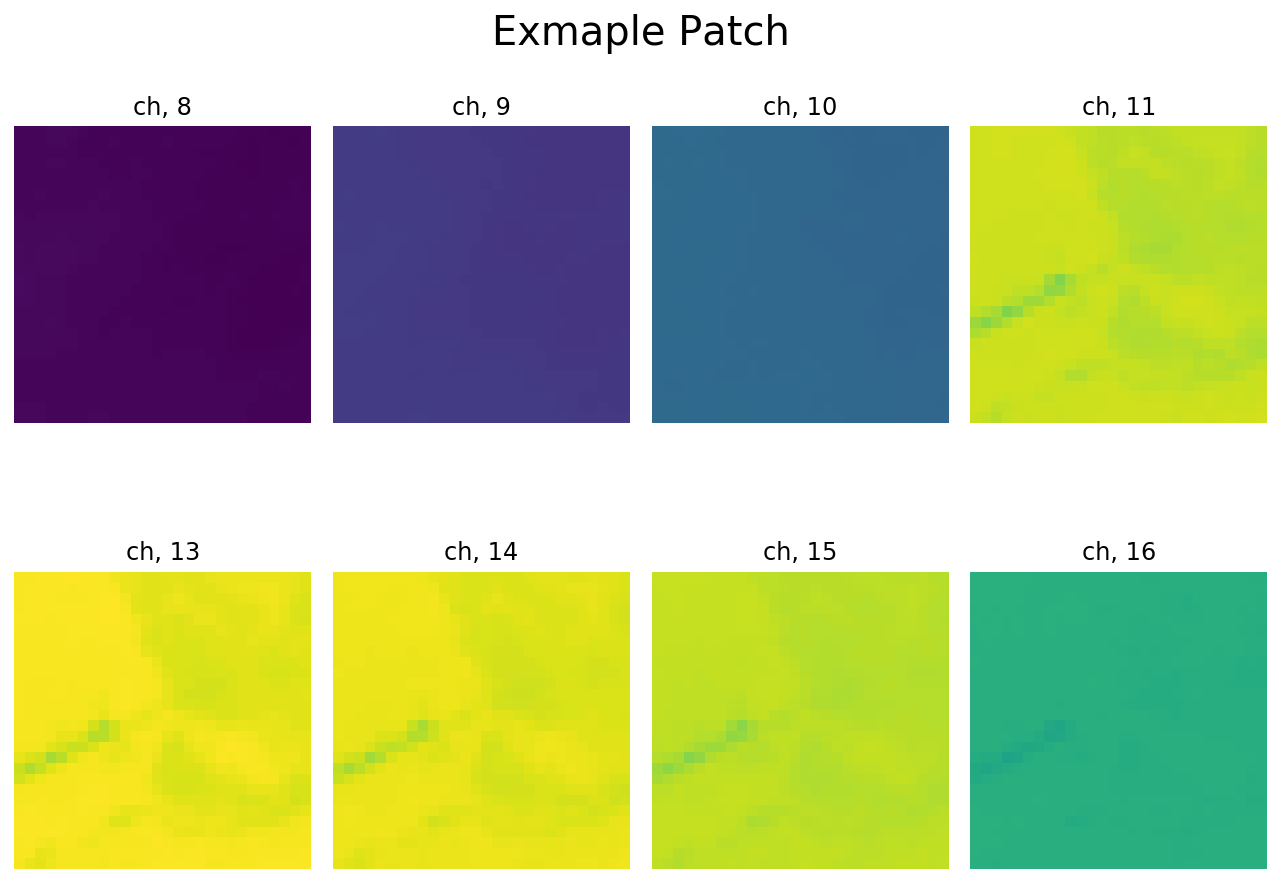

In [68]:
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(goes16.bands[i])}')
fig.tight_layout()

In [16]:
xar = xr.open_dataset(vol + '/processed/abi_patches_TEST.nc')
xar

<xarray.Dataset>
Dimensions:  (band: 8, patch: 134, x: 28, y: 28)
Coordinates:
  * patch    (patch) int64 0 1 2 3 4 5 6 7 8 ... 126 127 128 129 130 131 132 133
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 18 19 20 21 22 23 24 25 26 27
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 18 19 20 21 22 23 24 25 26 27
  * band     (band) int64 8 9 10 11 13 14 15 16
Data variables:
    abi      (patch, band, y, x) float32 ...
    time     (patch) float64 ...
    lon      (patch, y, x) float32 ...
    lat      (patch, y, x) float32 ...

In [17]:
xar.abi.values.shape

(134, 8, 28, 28)

In [13]:
xar.close()

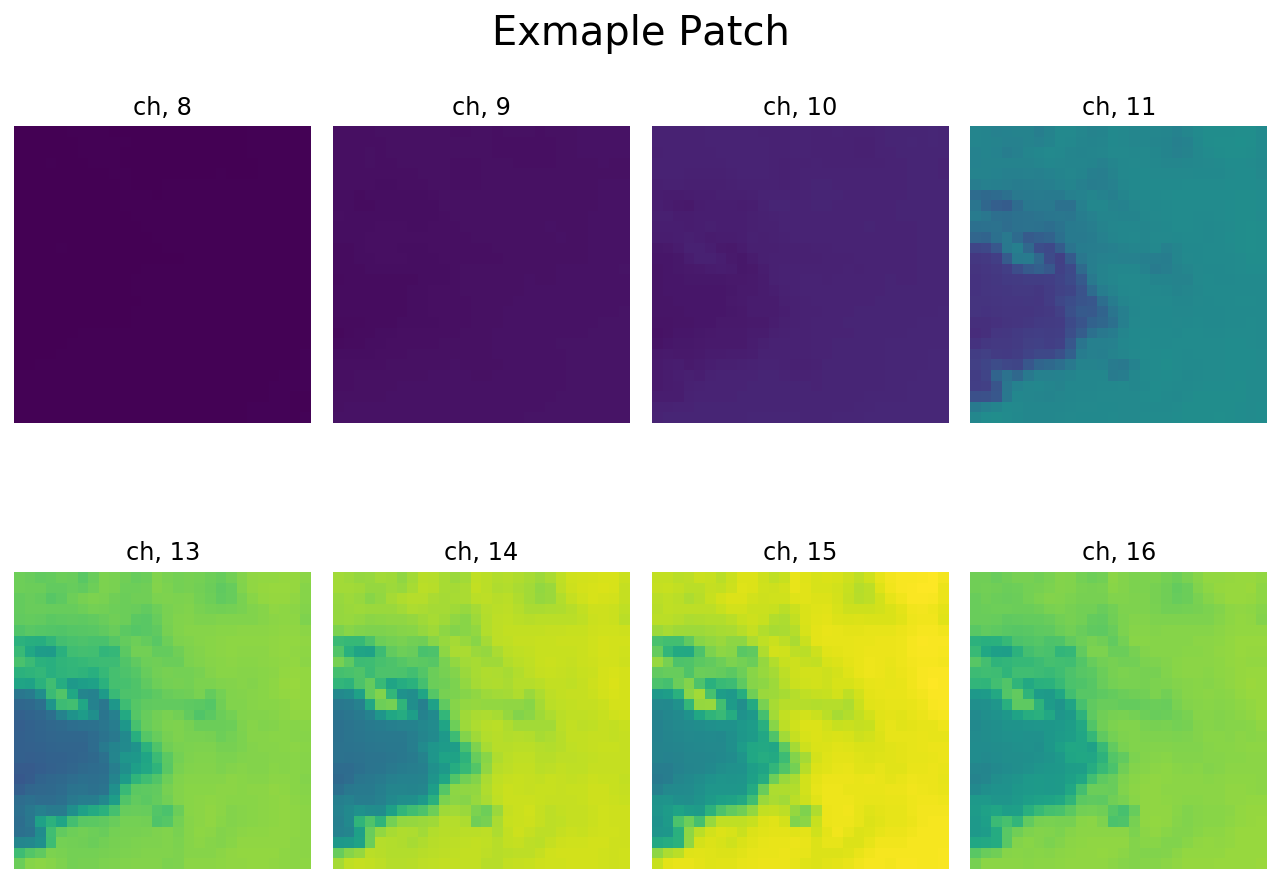

In [19]:
patch = xar.abi.values
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(xar.band.values[i])}')
fig.tight_layout()